# Set environment

In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from example_lorenz import get_lorenz_data, generate_lorenz_data
sys.path.append('../')
from autoencoder import Autoencoder
from training import create_feed_dictionary, sindy_simulate, train_network

Available GPUs: 1
GPU 0: NVIDIA GeForce RTX 3070 Ti Laptop GPU
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce RTX 3070 Ti Laptop GPU


### Retrieving data files

In [2]:
data_path           = os.getcwd() + '/'
save_name           = 'lorents_model_analysed'
params              = pickle.load(open('lorenz_trained_model.pkl', 'rb'))
params['save_name'] = data_path + save_name

### Generating test data

In [3]:
# Generate data
t                   = np.arange(0,20, 0.01)
z0                  = np.array([[-8, 7, 27]])
test_data           = generate_lorenz_data(z0, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40])) 
test_data['x']      = test_data['x'].reshape((-1,params['input_dim']))
test_data['dx']     = test_data['dx'].reshape((-1,params['input_dim']))
test_data['z']      = test_data['z'].reshape((-1,params['latent_dim']))
test_data['dz']     = test_data['dz'].reshape((-1,params['latent_dim']))

# Save data
pickle.dump(test_data, open(data_path + 'lorentz_test_data.pkl', 'wb'))

### Plotting Loss evolution of the training loop

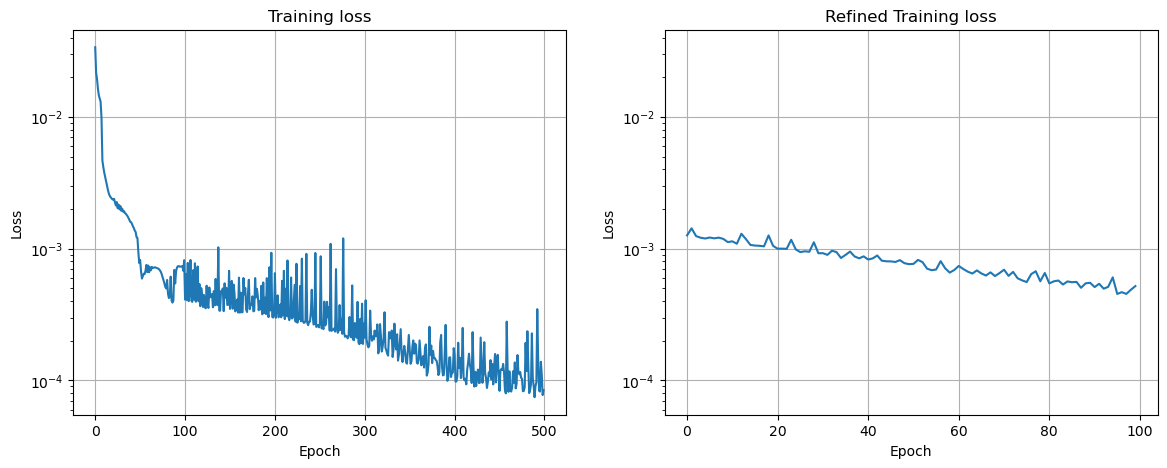

Loss last epoch:			 8.445965e-05
Training Loss epoch 100: 		 0.00081827503
Refined training Loss epoch 100: 	 0.00052018487


In [21]:
total_loss                  = params['loss_decoder']
validation_loss             = params['validation_losses']
refined_losses              = params['refined_losses']
refined_validation_losses   = params['refined_validation_losses']
# Plot losses as a function of iteration for nominal and validation
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].semilogy(total_loss)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training loss')
ax[0].grid()
# Set the y-axis limit of ax[1] to be the same as ax[0]
ax[1].set_ylim(ax[0].get_ylim())
ax[1].semilogy(refined_losses)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Refined Training loss')
ax[1].grid()
plt.show()
# Total loss
print('Loss last epoch:\t\t\t', total_loss[-1])
print('Training Loss epoch 100: \t\t', total_loss[99])
print('Refined training Loss epoch 100: \t', refined_losses[99])

# Simulations

In [24]:
autoencoder_network = Autoencoder(params)
test_dict = create_feed_dictionary(test_data, params)
print(test_dict)

{'x': tensor([[0.0058, 0.0441, 0.0755,  ..., 0.7566, 0.8517, 0.9549],
        [0.0512, 0.0824, 0.1076,  ..., 0.7400, 0.8261, 0.9193],
        [0.0912, 0.1167, 0.1369,  ..., 0.7247, 0.8032, 0.8879],
        ...,
        [0.1464, 0.1402, 0.1340,  ..., 0.3085, 0.3203, 0.3325],
        [0.1392, 0.1332, 0.1272,  ..., 0.3179, 0.3297, 0.3418],
        [0.1321, 0.1262, 0.1204,  ..., 0.3292, 0.3410, 0.3531]]), 'dx': tensor([[ 4.8145,  4.0281,  3.3441,  ..., -1.6976, -2.6865, -3.7835],
        [ 4.2668,  3.6319,  3.0800,  ..., -1.6009, -2.4280, -3.3433],
        [ 3.7378,  3.2224,  2.7747,  ..., -1.4701, -2.1644, -2.9311],
        ...,
        [-0.7153, -0.6970, -0.6779,  ...,  0.8614,  0.8520,  0.8415],
        [-0.7177, -0.6996, -0.6806,  ...,  1.0323,  1.0282,  1.0232],
        [-0.7170, -0.6994, -0.6809,  ...,  1.2227,  1.2247,  1.2261]]), 'coefficient_mask': tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
  